# Important Notes & Resources

**Purpose & Learning Goals**

The purpose of problem set 3 is to practice implementing an optimization model. This serves our learning goal of developing a design toolkit that includes methods from engineering. During this problem set, you will also practice implementing and interpreting data analysis related to equitable education policies.

**Getting Started**

To get started, first save a copy of this colab notebook to your "My Drive". You will also need to save 4 files to your "My Drive": "opt_inputs.pickle", "table2.csv", "table3.csv", and "assignment.py"

Make sure that you are running this notebook with GPU-enabled support. To do this, go to `Runtime` > `Change runtime type` in the top toolbar and select GPU for the hardware accelerator, as in the screenshot below. Click save.



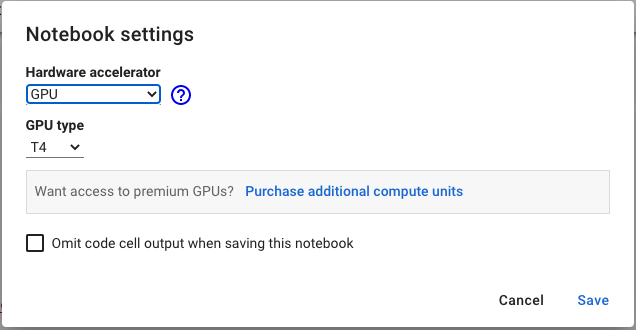

Check if your GPU is enabled by running the cell below. If the output is `/device:GPU:0`, you are good to go!

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Now load in the modules you need for this problem set.

In [2]:
#Run this cell first by hitting the play button to load packages that you'll need in this pset
from google.colab import drive
import matplotlib.pyplot as mplt
import numpy as np
import pandas as pd
import seaborn as sb
import sys

#mount drive and add to path
drive.mount('/content/drive')
FOLDERNAME = "Stanford Summer Session/DATASCI 154/PS3"

#import custom module for part 2
from importlib.machinery import SourceFileLoader
module = SourceFileLoader("assignment", f"/content/drive/My Drive/{FOLDERNAME}/assignment.py").load_module()
from assignment import SchoolAssigner

Mounted at /content/drive


#Choosing which data to use

In this part, we will explore some of the challenges of deciding which data to use, especially when the datasets are small and exact measurement is not always possible. We will do this in the context of the San Francisco Unified School District (SFUSD) school choice redesign project.

The redesign had three primary goals:
- **Diversity:** schools should be socioeconomically and racially representative of the district as a whole.
- **Proximity:** students should be able to go to school close to home.
- **Predictability**: families should have a right to predictability, simplicity, and transparency as they go through the student assignment system.

Suppose you are tasked with measuring these objectives. Visit [this spreadsheet](https://docs.google.com/spreadsheets/d/1QXRGBwyRPbk7UMLwbQoeUTZmXLr_WXMnNgKXGBE-Fw8/edit#gid=0) to view the metadata (description of the data) that is available to you. You will use this information to decide which data to use to measure these objectives.

*Hint:* *When deciding on which data to use and determining limitations of data, consider the following. As opposed to the more common neighborhood assignment system, which assigns all students within a single neighborhood to the same school, a school choice system like the one SFUSD is redesigning allows students within the same neighborhood to make different choices about which schools they prefer. This means that the assignment process takes into account individual student preferences, and so the evaluation of outcomes will need to take into account individual student assignments and demographics.*

  1. First, we'll consider the diversity goal for socioeconomic status. List all the available measures of socioeconomic status.

freelunch_prob: The greater, the greater the proportion of lower socioeconomic status

reducedlunch_prob: The greater, the greater the proportion of lower socioeconomic status

median_hh_income: The lower, the greater the proportion of lower socioeconomic status

2. The metadata includes aggregate (rather than individual) measures of socioeconomic status. What are the benefits and limitations to this approach, considering that school choice uses individual preferences? Which of the aggregate measures would you use to measure socioeconomic diversity? Justify your choice by dicussing alternatives and why they are less suitable.

Benefits:

*   Individual student's privacy is protected, especially concerning more senstive information like socioeconomic status
*   Using aggregated data simplifies the process of gathering, and analyzing the information, since the data is now less complex and more manageable/interpretable
*   Bias towards/against certain clusters using aggregated data is greatly reduced, since groups are treated as a whole as opposed to zooming in on individual characteristics

Limitations:

*   School choice uses individual preferences, with respect to their individual circumstances. Aggregated data might not fully capture the nuances of their situation, limiting the amount/type of help during interventions. Thus data should also be on an individual level to ensure the student gets the help necessary to meet their specific preferences
*   Aggregation averages out the data, thus can also said to be averaging out the resources/help, which ultimately leads to inequitable resource allocation and therefore little to no observed difference in equity

I would use freelunch_prob, reducedlunch_prob, and median_hh_income.

freelunch_prob and reducedlunch_prob measure the fraction of students in the student's census block who have a lower socioeconomic status, thus this provides an overview of the diversity. An ideal fraction would be somewhere along 50%. This is a better measure than using school records to see if the student registered/bought school meal plans, for example, as that could be due to a various numbers of factors like convenience or social pressure, and thus not truly representative of socioeconomic diversity within a school.

Median Household income is a better aggregate measure than mean, since it would not be skewed by a small number of extremely high or low-income households, which might not be representative of the majority. It is a necessary measure, and better than individual income as based on individual income alone, there would be no comparison with the other students in the school, and the number would mean less in isolation.

Among freelunch_prob, reducedlunch_prob, and median_hh_income however, I would use freelunch_prob, reducedlunch_prob as it is more telling of the socioeconomic diversity in a school.

3. Next, we'll consider the proximity goal. List all the available measures of student location. *(Hint: see this [documentation](https://www2.census.gov/geo/pdfs/reference/GARM/Ch11GARM.pdf) for an explanation of census geographic areas.)*

census_block， census_blockgroup， census_tract, latitude, longitude, zipcode

4. The metadata includes several ways to measure student location at different levels of granularity and from different data sources. Which of these measures would be most useful to measure the proximity objective? Justify your choice by discussing alternatives and why they are less suitable.

longitude and latitude would be the most precise, but if they are not available, they default to those of their attendance area school, which becomes much less useful since we want the distance from their house to their school to begin with.

In descending order of location precision and specificity, census_block > census_blockgroup > census_track. However, census_block still is not specific enough since it contains a chunk that affects the distance from the house to the school.

zipcode would be the worst measure, since the area captured by a zipcode is huge and could contain many census blocks, resulting in an ineffective way to measure proximity

Optimizing for Objectives

In this part, you will solve a slight reformulation of the school choice problem in Lecture 2. As a reminder, we originally formulated the school choice problem as an **assignment** problem. The task is to assign students to schools subject to constraints, as shown below.

### Original school choice problem:

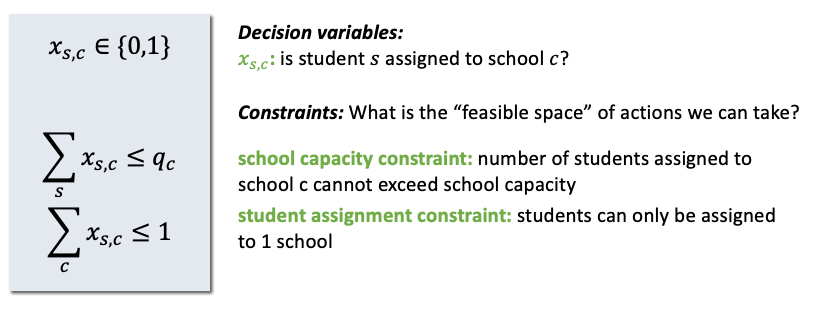

For this question, we will re-formulate the problem at a higher level of aggregation than the student with a continuous decision variable. We will introduce the concept of a **student type**, which will be a combination of census tract and student ethnicity. For example, one type would be White students who live in census tract 6075020500.

### New school choice problem:

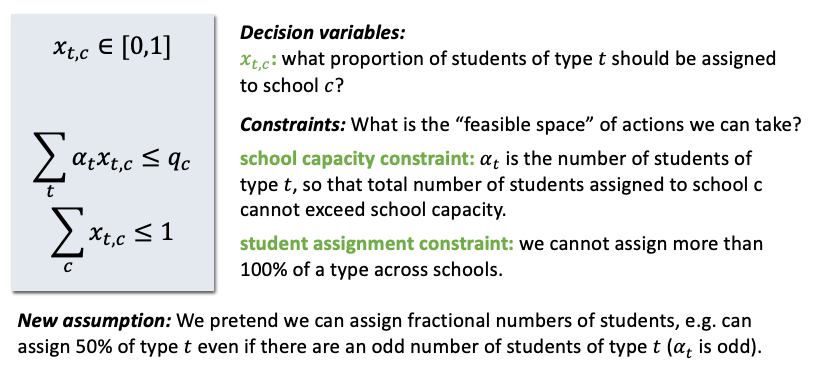

## Measuring trade-offs with multiple objectives

The district's objectives require trade-offs; for example, the proximity and diversity goals are often in opposition due to residential segregation. To understand this particular trade-off, we need to measure both the proximity and the racial and ethnic representativeness of our school assignments.

There are several ways to measure **diversity**. One metric, known as dissimilarity, measures the percentage of students from different socioeconomic or racial backgrounds that would need a different assignment for every school to be representative of the district. We can measure **distance** as the average distance between students and their assigned schools. To see the mathematical formulation of these objectives, you can read [this documentation](https://colab.research.google.com/drive/1PoeMqIj5_Wg6JTfZpaNXHYld3zSJe5tD#scrollTo=oMDOatkooNyo).

We can combine our distance and diversity objectives using a parameter $\lambda \in [0,1]$. Varying $\lambda$ allows us to pick how much we care about the two objectives relative to each other (e.g., $\lambda = 1$ implies we only care about distance, $\lambda = 0$ implies we only care about diversity).

$$
\text{min} \quad \lambda \text{OBJ}_{dist} + (1-\lambda)\text{OBJ}_{div}
$$

We have implemented this weighted objective in a custom class called `SchoolAssigner`. Run the cell below to see an example of how to use it.

In [5]:
#EXAMPLE USAGE

#instantiate SchoolAssigner using input data (you only need to do this once!)
assigner = SchoolAssigner(f'/content/drive/My Drive/{FOLDERNAME}/opt_inputs.pickle')

#compute an assignment using lambda = 0.1
assigner.assign_students(0.1)

#print stored values of distance and diversity objectives
print((assigner.distance, assigner.diversity))

Optimizing assignment for lambda = 0.1...
Solution converged in 3.73 seconds
1.2226931513180441 0.00015365520898508666


5. Using 10 evenly spaced values between 0 and 1 for lambda, use `SchoolAssigner` to compute the two objectives for each value of $\lambda$ and store each set of values in a dataframe.

*Hint: To get a list of 10 evenly spaced values between 0 and 1, use `np.linspace(0,1,10)`.*

In [6]:
#Compute objectives at different values of lambda
#For each objective, store the value in a list for each value of lambda

objectives_dict = {"lambda_vals": [], "distances": [], "diversities": []}
for lambda_val in np.linspace(0,1,10):
  assigner.assign_students(lambda_val)
  objectives_dict["lambda_vals"].append(lambda_val)
  objectives_dict["distances"].append(assigner.distance)
  objectives_dict["diversities"].append(assigner.diversity)

df = pd.DataFrame(objectives_dict)
df

Optimizing assignment for lambda = 0.0...
Solution converged in 1.71 seconds
Optimizing assignment for lambda = 0.11...
Solution converged in 3.18 seconds
Optimizing assignment for lambda = 0.22...
Solution converged in 5.35 seconds
Optimizing assignment for lambda = 0.33...
Solution converged in 4.98 seconds
Optimizing assignment for lambda = 0.44...
Solution converged in 8.90 seconds
Optimizing assignment for lambda = 0.56...
Solution converged in 17.59 seconds
Optimizing assignment for lambda = 0.67...
Solution converged in 6.94 seconds
Optimizing assignment for lambda = 0.78...
Solution converged in 8.74 seconds
Optimizing assignment for lambda = 0.89...
Solution converged in 7.30 seconds
Optimizing assignment for lambda = 1.0...
Solution converged in 2.87 seconds


,lambda_vals,distances,diversities
0,0.000000,1.500000,0.000009
1,0.111111,1.222672,0.000154
2,0.222222,1.213145,0.016004
3,0.333333,1.088686,0.105522
4,0.444444,1.027388,0.183168
5,0.555556,0.975621,0.233381
6,0.666667,0.959401,0.320767
7,0.777778,0.921469,0.423573
8,0.888889,0.917631,0.495784
9,1.000000,0.900500,0.620952


6. Plot the trade-off curve with $OBJ_{dist}$ on the x-axis and $OBJ_{div}$ on the y-axis.  Your code should produce a graph that looks like the figure below:

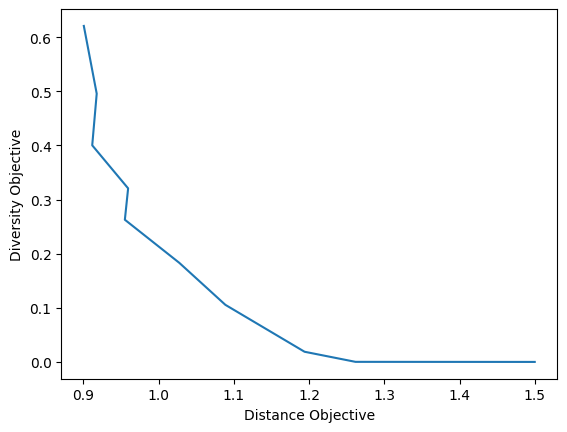

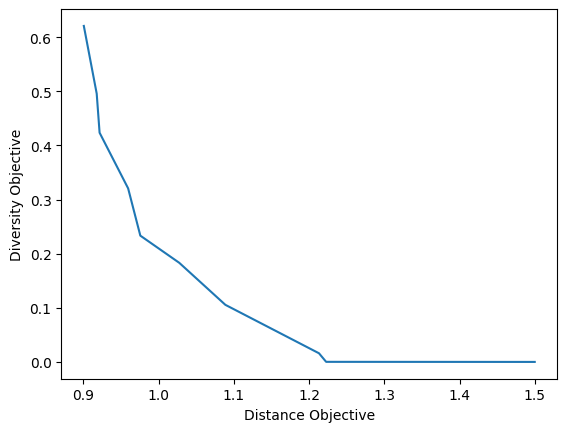

In [11]:
#plot the tradeoff curve

mplt.plot(df["distances"], df["diversities"])
mplt.xlabel("Distance Objective")
mplt.ylabel("Diversity Objective")
mplt.show()

#Part 3: Evaluating assignment policies

In the actual school choice redesign, several objectives were computed for four possible assignment policies:

- **Zones:** Families are restricted to choose programs at schools in medium-sized zones around their home.
- **Zones + Reserves**: Families are restricted to choose programs at schools in medium-sized zones around their home, with seats held in reserve to achieve diversity goals.
- **Priorities:** Priority is given to certain underserved groups (e.g., lowest test scores).
- **2018-2019 Assignment:** Results of actual district-wide choice in 2018-19, guided by 58 contiguous 'attendance areas' that serve as the neighborhood for one school, with a priority and lottery system to assign students to over-demanded schools.

In this part, you will evaluate the four assignment policies on a variety of performance metrics related to the redesign goals. The table below shows an example of this type of evaluation from lecture.

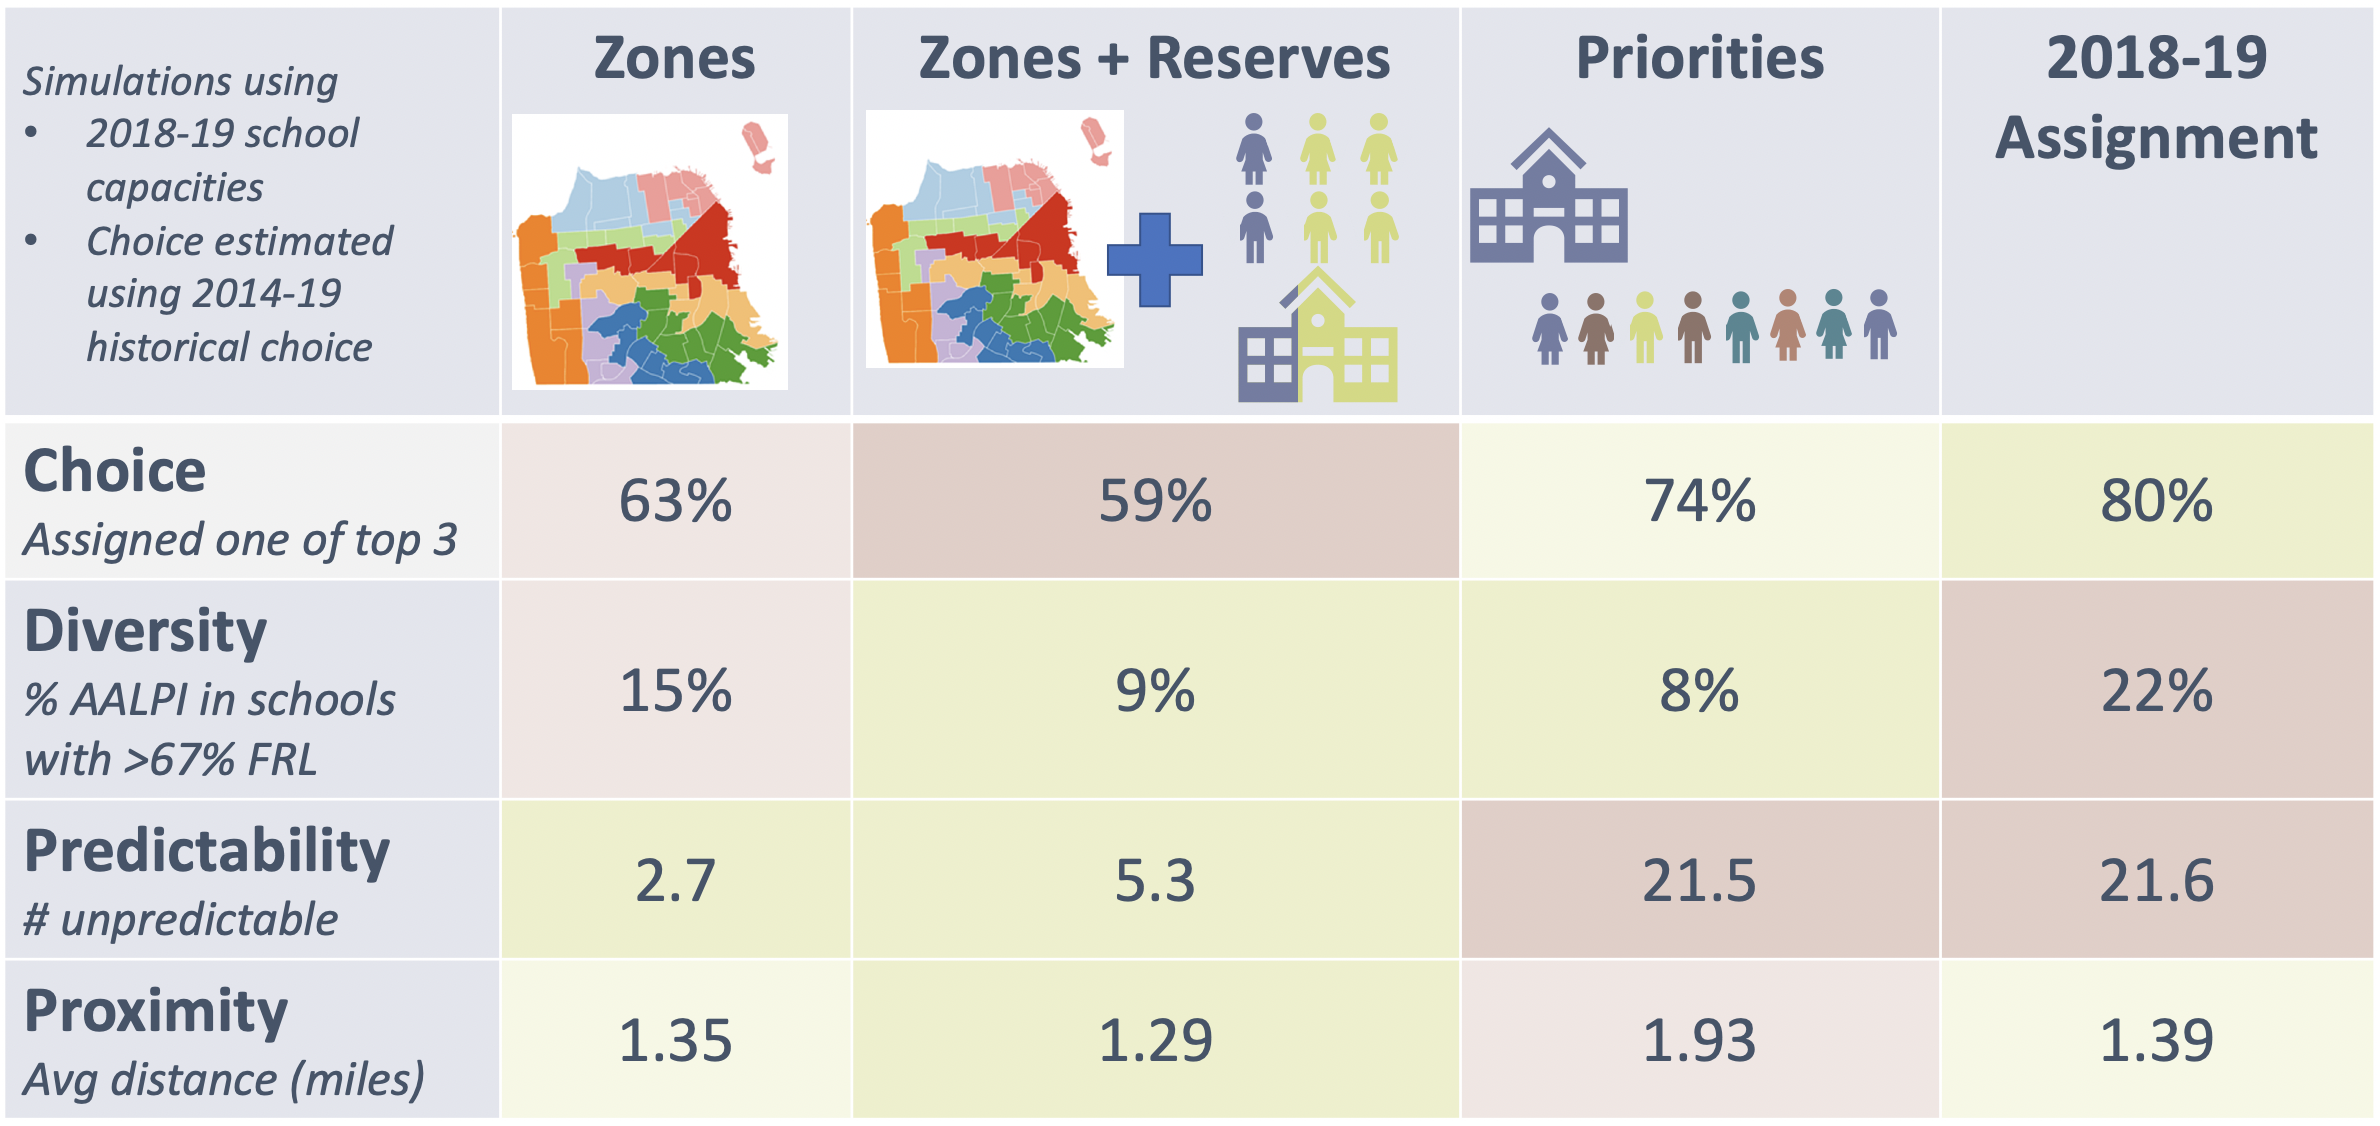

Run the cell below to load in the data from Table 2 in [the paper](https://www.uts.edu.au/sites/default/files/2022-06/SFUSD_Policy_Paper_Draft.pdf) and print the first few rows. Each row represents an evaluation metric (specified in the `Metric` column) associated with each assignment policy (specified in the `Policy` column).



In [12]:
#Read in table 2 data
table2 = pd.read_csv(f'/content/drive/My Drive/{FOLDERNAME}/table2.csv')

#inspect first few rows
table2.head()

,Policy,Metric,Value
0,Zones,Avg. Distance,1.35
1,Zones + Reserves,Avg. Distance,1.29
2,Priorities,Avg. Distance,1.91
3,2018-2019,Avg. Distance,1.39
4,Zones,Distance <= 0.5,0.30


7. Adapt the code template in the cell below to make a barplot of one of the metrics from the following list:

- Distance $\leq 0.5$ miles: Percentage of students within a walking distance of 0.5 miles.
- Distance $\geq 3$ miles: Percentage of students assigned further than 3 miles from home.
- +15% FRL Schools: Percentage of schools where the FRL average of students assigned to the school is greater than 15% above the fraction of students eligible for FRL district-wide.
-Rank Top 1: Number of students receiving their top choice.


[Text(0.5, 0, ''), Text(0, 0.5, 'Distance <= 0.5')]

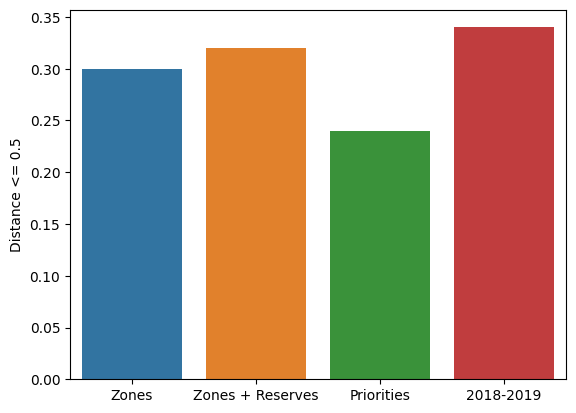

In [18]:
#####################################################################
## EXAMPLE CODE
#####################################################################
#Select metric (replace 'Avg. Distance' with your chosen metric)
# plot_data = table2.loc[(table2.Metric == 'Avg. Distance'),]

# #Template for bar plot using average distance metric
# fig, ax = mplt.subplots()
# sb.barplot(data = plot_data, x = 'Policy', y = 'Value',
#             dodge = False, ax = ax)
# ax.set(xlabel = '', ylabel = 'Avg. Distance')

######################################################################
### YOUR ADAPTED CODE HERE USING A METRIC FROM THE LIST ABOVE
#####################################################################

plot_data = table2.loc[(table2.Metric == 'Distance <= 0.5'),]

#Template for bar plot using average distance metric
fig, ax = mplt.subplots()
sb.barplot(data = plot_data, x = 'Policy', y = 'Value',
            dodge = False, ax = ax)
ax.set(xlabel = '', ylabel = 'Distance <= 0.5')

8. Interpret your plot. Which policy does the best according to this metric? The worst?

Based on the values (Percentage of students within a walking distance of 0.5 miles),

The 2018-2019 assignment policy does the best, giving nearly 35% of students a walking distance within 0.5 miles, while priorities does the worst, giving only less than 25% of students a walking distance within 0.5 miles.

We also want to perform evaluations by race and ethnicity. Run the cell below to load in the data from Table 3 in [the paper](https://www.uts.edu.au/sites/default/files/2022-06/SFUSD_Policy_Paper_Draft.pdf) and inspect a few rows. Each row represents an evaluation metric (specified in the `Metric` column) associated with each assignment policy (specified in the `Policy` column), split by ethnicity (specified in the `Group` column).


In [22]:
#Read in table 3 data
table3 = pd.read_csv(f'/content/drive/My Drive/{FOLDERNAME}/table3.csv')

#inspect first few rows
table3.head()

,Policy,Group,Metric,Value
0,Zones,African American,Avg. Distance,1.45
1,Zones + Reserves,African American,Avg. Distance,1.27
2,Priorities,African American,Avg. Distance,2.24
3,2018-2019,African American,Avg. Distance,1.82
4,Zones,Asian,Avg. Distance,1.43


9. Adapt the code template in the cell below to make a barplot of one of the metrics from the following list:

- In + 15% FRL: Percentage of schools where the FRL average of students assigned to the school is greater than 15% above the fraction of students eligible for FRL district-wide.
- Dist >= 3, Rank >=5: Percentage of students assigned at least 3 miles away from their home to a program they ranked 5th or higher.

[Text(0.5, 0, ''), Text(0, 0.5, 'Dist >= 3, Rank >= 5')]

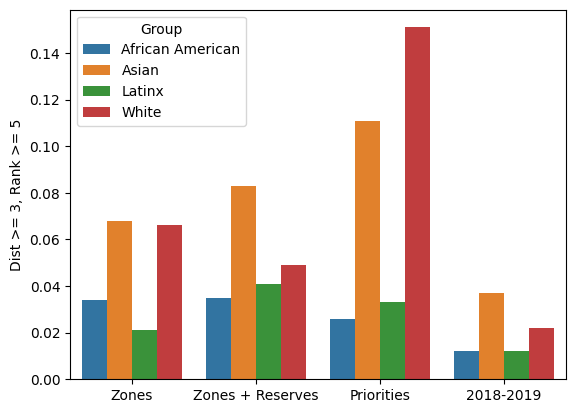

In [24]:
#####################################################################
## EXAMPLE CODE
#####################################################################

#Select metric (replace 'Avg. Distance' with your chosen metric)
# plot_data = table3.loc[(table3.Metric == 'Avg. Distance'),]

# #Template for bar plot using average distance metric
# fig, ax = mplt.subplots()
# sb.barplot(data = plot_data, x = 'Policy', y = 'Value', hue = 'Group')
# ax.set(xlabel = '', ylabel = 'Avg. Distance')

#####################################################################
## YOUR ADAPTED CODE USING A METRIC FROM THE LIST ABOVE
#####################################################################

plot_data = table3.loc[(table3.Metric == 'Dist >= 3, Rank >= 5'),]

#Template for bar plot using average distance metric
fig, ax = mplt.subplots()
sb.barplot(data = plot_data, x = 'Policy', y = 'Value', hue = 'Group')
ax.set(xlabel = '', ylabel = 'Dist >= 3, Rank >= 5')

10. Interpret your plot. Do any of the policies appear to advantage or disadvantage particular groups?


Priorities seems to have the greatest disparity, advantaging African American and Latinx while disadvantaging White and Asians (Whites more than Asians). This disparity is at least 3 times.

However, by the Zones + Reserves policy, only Asians are disproportionately disadvantaged while the other groups have similar percentages.

The 2018-2019 policy however seems to have the lowest percentages of students being assigned to schools at least 3 miles away from their home to a program they ranked 5th or higher, but Asians are still disadvantaged.

In [26]:
# If it contains spaces, use '\ ' to represent each space E.g. 'Summer\ PSet\ 1.ipynb'
FILENAME = "PS3_AndrewYu.ipynb"

%cd drive/My\ Drive
%cd $FOLDERNAME
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!pip install PyPDF2
!jupyter nbconvert --log-level CRITICAL --to pdf $FILENAME

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive/Stanford Summer Session/DATASCI 154/PS3
[Errno 2] No such file or directory: 'Stanford Summer Session/DATASCI 154/PS3'
/content/drive/My Drive/Stanford Summer Session/DATASCI 154/PS3
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
